In [1]:
from modules.base import *

simple test

In [3]:
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))
llm = ChatOpenAI(model="gpt-4o")
for chunk in llm.stream(messages):
    print(f"\033[1;32m{chunk.content}\033[0m",end="")
    sys.stdout.flush()

The best place to see orcas in the United States is the Pacific Northwest, particularly the waters around the San Juan Islands in Washington State. This area is renowned for its resident orca populations, known as the Southern Resident Killer Whales. These orcas are frequently seen between late spring and early fall, although sightings can occur year-round.

Here are some specific locations where you might have a good chance of seeing orcas:

1. **San Juan Islands**: Orcas Island, San Juan Island, and Lopez Island are popular spots for orca watching. Friday Harbor on San Juan Island is a common departure point for whale-watching tours.

2. **Puget Sound**: Orcas can sometimes be spotted in the waters closer to Seattle, especially in the spring and summer.

3. **Strait of Juan de Fuca**: This body of water between Washington State and Vancouver Island is another area where orcas are commonly sighted.

4. **Olympic Peninsula**: Areas like Port Angeles offer whale-watching tours that vent

test with tool

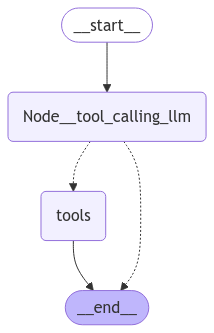

In [4]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

@auto_log_and_state
def Node__tool_calling_llm(state:MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("Node__tool_calling_llm", Node__tool_calling_llm)
builder.add_node("tools", ToolNode([multiply])) # execute tool when AI message is tool call
builder.add_edge(START, "Node__tool_calling_llm")
builder.add_conditional_edges("Node__tool_calling_llm",tools_condition)
builder.add_edge("tools", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
messages

args :  ({'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='c5814580-4719-4f14-9ae8-bec15ea4435f')]},)

🚀 Passing Through [Node__tool_calling_llm] ..

#### [Input State]
msg :  content='Hello!' additional_kwargs={} response_metadata={} id='c5814580-4719-4f14-9ae8-bec15ea4435f'
[HUMAN] : Hello!

#### [Output State]
msg :  content='Hi there! How can I assist you today?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 54, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'stop', 'logprobs': None} id='run-2a947b95-f9de-4514-a2af-b2b0c5e632a4-0' usage_metadata={'input_tokens': 54, 'output_tokens': 12, 'total_tokens': 66, 'i

{'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='c5814580-4719-4f14-9ae8-bec15ea4435f'),
  AIMessage(content='Hi there! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 54, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'stop', 'logprobs': None}, id='run-2a947b95-f9de-4514-a2af-b2b0c5e632a4-0', usage_metadata={'input_tokens': 54, 'output_tokens': 12, 'total_tokens': 66, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [5]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
messages


🚀 Passing Through [Node__tool_calling_llm] ..

#### [Input State] ..
[HUMAN] : Multiply 2 and 3

#### [Output State] ..
[AI] : Tool Call
  - Function Name: multiply
  - Function Arguments: {"a":2,"b":3}


{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='e2687b9c-84f4-43bf-9017-3b2b33730861'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WrqOimEx5x3H3JRLpTOeZj0O', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 58, 'total_tokens': 76, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4cc356f3-c546-4d26-a009-012197c9d466-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_WrqOimEx5x3H3JRLpTOeZj0O', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 1